In [1]:
%%capture
%%bash

pip install --upgrade diffusers transformers scipy
pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
pip install --upgrade flax

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
from diffusers import FlaxStableDiffusionPipeline

pipeline, pipeline_params = FlaxStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="bf16", dtype=jax.numpy.bfloat16
)

Downloading:   0%|          | 0.00/563 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.
  warnings.warn(warning + message, FutureWarning)
Some of the weights of FlaxStableDiffusionSafetyChecker were initialized in bfloat16 precision from the model checkpoint at /root/.cache/huggingface/diffusers/models--CompVis--stable-diffusion-v1-4/snapshots/295cccdedbd5f87458186972858dc85c7e70c10a/safety_checker:
[('concept_embeds',), ('concept_embeds_weights',), ('special_care_embeds',), ('special_care_embeds_weights',), ('vision_model', 'vision_model', 'embeddings', 'class_embedding'), ('vision_model', 'vision_model', 'embeddings', 'patch_embedding', 'kernel'), ('vision_model', 'vision_model', 'embeddings', 'position_embedding', 'embedding'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('vision_m

In [7]:
def generate(prompt, num_samples, seed=0, num_inference_steps=50, guidance_scale=7.5):
    prng_seed = jax.random.PRNGKey(seed)
    prompt = num_samples * [prompt]
    prompt_ids = pipeline.prepare_inputs(prompt)

    # shard inputs and rng
    params = replicate(pipeline_params)
    prng_seed = jax.random.split(prng_seed, num_samples)
    prompt_ids = shard(prompt_ids)

    output = pipeline(prompt_ids, params, prng_seed, num_inference_steps, guidance_scale=guidance_scale, jit=True)
    images = output.images
    images = np.asarray(images.reshape((num_samples,) + images.shape[-3:]))
    images = pipeline.numpy_to_pil(images)
    return images

Other painting style to try include: Expressionist, Oil, Surrealism. See more here - [link](https://www.pictoclub.com/types-of-painting-art-styles-mediums-subjects/)

In [6]:
prompt = "A road across trees with snow and moutains in the horizon in fresco style"

num_samples = jax.device_count()

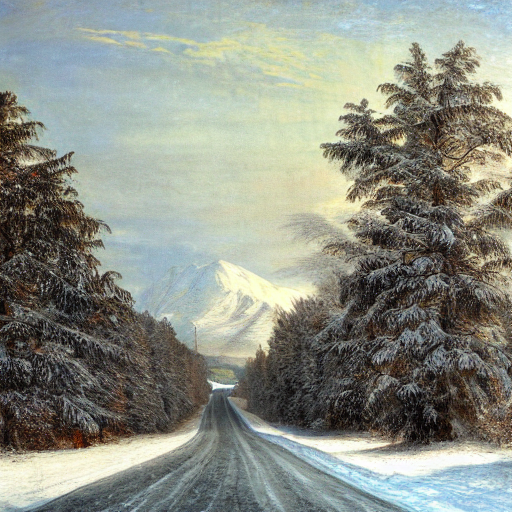

In [ ]:
images = generate(prompt, num_samples, seed=0)
images[0]

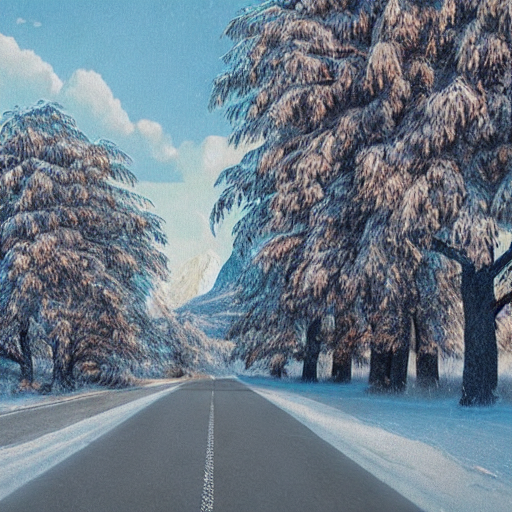

In [ ]:
images = generate(prompt, num_samples, seed=13)
images[0]

In [ ]:
images = []
for s in tqdm([0, 13, 31, 59]):
    for g in tqdm([1.1, 3, 7, 14], leave=False):
        output = generate(prompt, num_samples, seed=s, guidance_scale=g)
        images = images + output

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
def ceildiv(a, b):
    return -(-a // b)

def plots_pil_images(pil_images, figsize=(10,5), rows=1, cols=None, titles=None, maintitle=None):
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    cols = cols if cols else ceildiv(len(pil_images), rows)
    for i in range(len(pil_images)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = np.asarray(pil_images[i])
        plt.imshow(img)

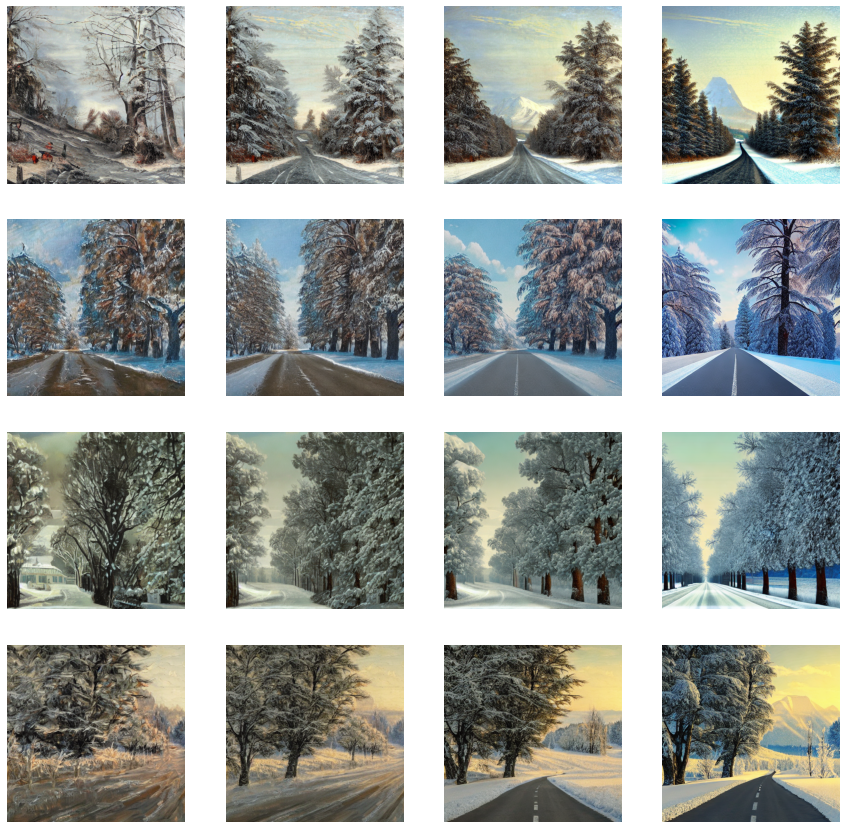

In [ ]:
plots_pil_images(images, figsize=(15, 15), rows=4, cols=4)

Negative prompt

In [41]:
def prepare_inputs(prompt, num_samples):
    prompt = num_samples * [prompt]
    prompt_ids = pipeline.prepare_inputs(prompt)
    prompt_ids = shard(prompt_ids)
    return prompt_ids

def generate(prompt, neg_prompt, num_samples, seed=0, num_inference_steps=50, guidance_scale=7.5):
    prng_seed = jax.random.PRNGKey(seed)
    prompt_ids = prepare_inputs(prompt, num_samples)
    neg_prompt_ids = prepare_inputs(neg_prompt, num_samples)

    # shard inputs and rng
    params = replicate(pipeline_params)
    prng_seed = jax.random.split(prng_seed, num_samples)

    output = pipeline(prompt_ids, params, prng_seed, num_inference_steps, guidance_scale=guidance_scale, jit=True,
                      neg_prompt_ids=neg_prompt_ids)
    images = output.images
    images = np.asarray(images.reshape((num_samples,) + images.shape[-3:]))
    images = pipeline.numpy_to_pil(images)
    return images

CPU times: user 34.5 s, sys: 1.41 s, total: 36 s
Wall time: 35.2 s


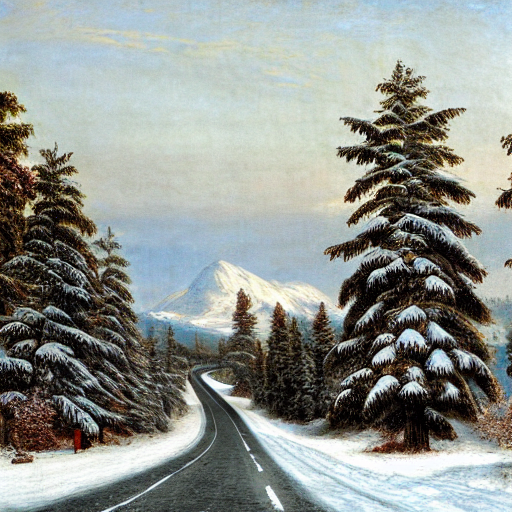

In [42]:
%%time

images = generate(prompt, 'shiny sun', num_samples, seed=0)
images[0]

CPU times: user 36.1 s, sys: 1.54 s, total: 37.7 s
Wall time: 36.9 s


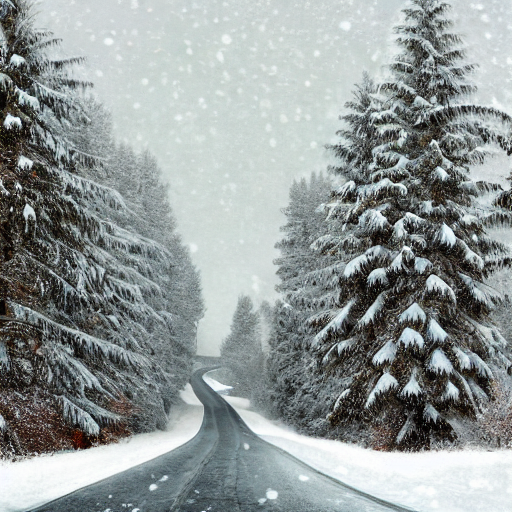

In [48]:
%%time

images = generate(prompt, 'sunset', num_samples, seed=0)
images[0]

CPU times: user 34.5 s, sys: 1.5 s, total: 36 s
Wall time: 35.3 s


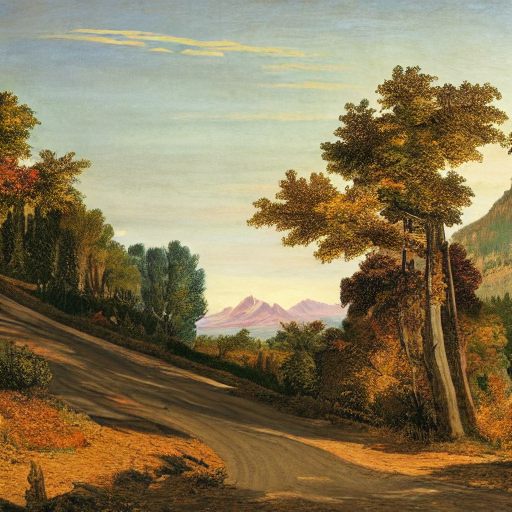

In [47]:
%%time

images = generate(prompt, 'snow storm', num_samples, seed=0)
images[0]